In [1]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Reading, Resizing and Normalizing the Filtered Images

In [23]:
images = []
labels = []
count = 1
for i in range(10):
    for filename in os.listdir('filtered_imgs/c'+str(i)):
            
            img = cv2.imread(str('filtered_imgs/c'+str(i)+'/'+filename))
            count = count +1
            labels.append(i)
            img = cv2.resize(img, (100,100))/255
            #print(img.shape)
            images.append(img)

In [24]:
len(images)

22424

In [25]:
images = np.asarray(images)

In [26]:
images.shape

(22424, 100, 100, 3)

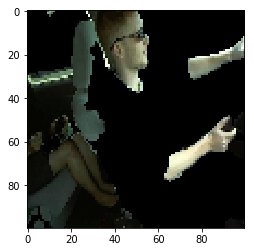

In [27]:
plt.imshow(images[0])

## Feature Extraction Using VGG16
Feature extraction is related to dimensionality reduction. When the input data is too large to be processed and is suspected to be reduntant (eg. repetitiveness of images presented as pixels) then it can be transformed into a reduced set of features (called feature vector)

Feature extraction actually transforms the attributes, the transformed attributes are linear combination of original attributes. 

In [32]:
import keras
from keras.models import Model 
from keras.layers import Dense,Conv2D,Dropout, Flatten


In [33]:
#load the VGG model and then we load the model architecture and imagenet weights
base = keras.applications.vgg16.VGG16(include_top=False,input_shape=(100,100,3),weights='imagenet')
#include_top: whether to include 3 fully connected layers at the top of the network
#input_shape is specified only when include_top is false

output = base.output

output = Flatten()(output)

model = Model(base.input, output)
for layer in base.layers:
    layer.trainable = False

In [34]:
feature_map = model.predict(images)

In [35]:
feature_map.shape

(22424, 4608)

## Modelling 

In [39]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_tar, test_tar = train_test_split(feature_map,labels,test_size=0.2,shuffle=True)

### K Nearest Neighbors

In [40]:
from sklearn.neighbors import KNeighborsClassifier as KNN
knn = KNN(n_neighbors=5)
knn.fit(train_data,train_tar)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [41]:
knn.score(test_data,test_tar)

0.9551839464882943

In [43]:
y_pred = knn.predict(test_data)

In [44]:
#classification report
from sklearn.metrics import confusion_matrix,classification_report
y_true = test_tar
class_names = ['safe driving','texting-right','talking on the phone - right','texting - left','talking on the phone - left','operating the radio','drinking','reaching behind',
              'hair and makeup','talking to passenger']
print(classification_report(y_true,y_pred,target_names=class_names))

                              precision    recall  f1-score   support

                safe driving       0.93      0.97      0.95       463
               texting-right       0.96      0.99      0.97       433
talking on the phone - right       0.95      0.98      0.97       449
              texting - left       0.95      0.92      0.94       491
 talking on the phone - left       0.90      0.96      0.93       436
         operating the radio       0.99      0.98      0.99       472
                    drinking       0.94      0.97      0.96       488
             reaching behind       0.98      0.98      0.98       401
             hair and makeup       0.97      0.84      0.90       403
        talking to passenger       0.98      0.95      0.96       449

                 avg / total       0.96      0.96      0.95      4485



### Support Vector Machine

In [45]:
from sklearn.svm import SVC
svc_classifiers = []
C_vals = [0.1,1.0,5,10]
for c in C_vals:
    clf1 = SVC(C=c)
    clf1.fit(train_data,train_tar)
    print(clf1.score(test_data,test_tar))
    svc_classifiers.append(clf1)

0.39420289855072466
0.7705685618729097
0.9103678929765886
0.9351170568561873


In [46]:
y_pred = clf1.predict(test_data)

In [47]:
#classification report 
from sklearn.metrics import confusion_matrix,classification_report
y_true = test_tar
class_names = ['safe driving','texting-right','talking on the phone - right','texting - left','talking on the phone - left','operating the radio','drinking','reaching behind',
              'hair and makeup','talking to passenger']
print(classification_report(y_true,y_pred,target_names=class_names))

                              precision    recall  f1-score   support

                safe driving       0.87      0.94      0.91       463
               texting-right       0.95      0.98      0.97       433
talking on the phone - right       0.95      0.96      0.96       449
              texting - left       0.94      0.92      0.93       491
 talking on the phone - left       0.89      0.92      0.90       436
         operating the radio       0.99      0.97      0.98       472
                    drinking       0.94      0.94      0.94       488
             reaching behind       0.96      0.97      0.96       401
             hair and makeup       0.92      0.83      0.87       403
        talking to passenger       0.94      0.92      0.93       449

                 avg / total       0.94      0.94      0.93      4485



### CNN-A

In [52]:
train_data, test_data, train_tar, test_tar = train_test_split(images,labels,test_size=0.2,shuffle=True)

In [53]:
from keras.models import Model
from keras.layers import Dense,Conv2D, Dropout, Flatten

model_cnn = keras.models.Sequential()

model_cnn.add(Conv2D(256,3,input_shape= (100,100,3),activation='relu'))
model_cnn.add(keras.layers.MaxPooling2D(3))
model_cnn.add(Dropout(0.3))

model_cnn.add(Conv2D(128,7,activation='relu'))
model_cnn.add(keras.layers.MaxPooling2D(3))
model_cnn.add(Dropout(0.3))

model_cnn.add(Conv2D(64,5,input_shape= (100,100,3),activation='relu'))
model_cnn.add(keras.layers.MaxPooling2D(3))
model_cnn.add(Dropout(0.3))

model_cnn.add(Flatten())

model_cnn.add(Dense(200,activation='relu'))
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(10,activation='softmax'))

In [54]:
model_cnn.compile(optimizer = 'adam', loss= 'sparse_categorical_crossentropy',metrics= ['accuracy'])


In [55]:
history = model_cnn.fit(train_data,train_tar,epochs=10,validation_split=0.1,batch_size=32)

Train on 16145 samples, validate on 1794 samples
Epoch 1/10
16145/16145 [==============================] - 1859s 115ms/step - loss: 1.4086 - acc: 0.4954 - val_loss: 0.5529 - val_acc: 0.8255
Epoch 2/10
16145/16145 [==============================] - 1844s 114ms/step - loss: 0.6426 - acc: 0.7854 - val_loss: 0.3182 - val_acc: 0.9052
Epoch 3/10
16145/16145 [==============================] - 1825s 113ms/step - loss: 0.4750 - acc: 0.8416 - val_loss: 0.2200 - val_acc: 0.9309
Epoch 4/10
16145/16145 [==============================] - 1882s 117ms/step - loss: 0.3796 - acc: 0.8783 - val_loss: 0.2018 - val_acc: 0.9381
Epoch 5/10
16145/16145 [==============================] - 2197s 136ms/step - loss: 0.3255 - acc: 0.8940 - val_loss: 0.1585 - val_acc: 0.9493
Epoch 6/10
16145/16145 [==============================] - 9349s 579ms/step - loss: 0.2863 - acc: 0.9067 - val_loss: 0.1639 - val_acc: 0.9543
Epoch 7/10
16145/16145 [==============================] - 2094s 130ms/step - loss: 0.2675 - acc: 0.9133 -